# Лабораторная работа №3
## Исследование нейронных сетей с радиальными базисными функциями (RBF) на примере моделирования булевых выражений

In [1]:
import math
import matplotlib.pyplot as plt

from functools import reduce
from itertools import product, chain, repeat
from more_itertools import distinct_permutations

In [18]:
# Норма обучения
N = 0.3

# Макс количество эпох
EPOCH = 100

# Минимальное изменение весов
EPS = 10e-5

# Задаем БФ и функции активаций по вариантам
function = lambda x1, x2, x3, x4: (not x3 or x4) and not x1 or x2

f1 = lambda net: 1 if net >= 0 else 0
df1 = lambda net: 1

_f2 = lambda net: 1. / (1. + math.exp(-net))
f2 = lambda net: 1 if _f2(net) >= 0.5 else 0
df2 = lambda net: _f2(net) * (1. - _f2(net))

In [3]:
# Все булевы наборы от i переменных
sets = lambda i: ((X, int(function(*X))) for X in product((0, 1), repeat=i))

# Подмножество по маске
subset = lambda i, M: (Xy for Xy, m in zip(sets(i), M) if m)

# Маска с 'o' единицами в наборе длины 'w'
r_masks = lambda o, w: distinct_permutations([*repeat(1, o), *repeat(0, w - o)])
f_masks = lambda o, w: reversed(list(r_masks(o, w)))

In [4]:
# Вычисляем функцию для всех входных векторов
Ys = [y for X, y in sets(4)]

ones = sum(Ys)
zeros = len(Ys) - ones

# Вычисляем количество RBF-нейронов
J = min(ones, zeros)

# Находим точки, в которых располагаем центры RBF-нейронов
C = [X for X, y in sets(4) if y == (1 if ones < zeros else 0)]

Ys, C

([1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1],
 [(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)])

In [5]:
# Функционирование и обучение сети
rbfF = lambda X, C: math.exp(-sum((x - c) ** 2 for x, c in zip(X, C)))
netF = lambda V, F: sum(v * f for v, f in zip(V, chain([1.], F)))
errF = lambda t, y: t - y
dltF = lambda F, d, df: [N * d * f * df for f in chain([1.], F)]
hamF = lambda T, Y: sum(t != y for t, y in zip(T, Y))
difF = lambda V0, V1: sum(abs(v1 - v0) for v0, v1 in zip(V0, V1))

In [32]:
def pipeline(f, df, mask):
    # Веса
    V0 = [0. for _ in range(J + 1)]

    # Проходим EPOCH эпох
    for i in range(EPOCH):

        # Сохраняем целевой вектор и вектор ответов нашей сети
        T = list()
        Y = list()

        # Идем по всем наборам
        for X, t in sets(4):

            # Считаем ответы RBF нейронов
            F = [rbfF(X, c) for c in C]

            # Реальный выход НС
            y = f(netF(V0, F))

            # Записываем вектора обучающих значений и полученных значений
            T.append(t)
            Y.append(y)
        
        # Расстояние хемминга
        E = hamF(T, Y)

        # Отдаем оценочные данные
        yield (i, V0, Y, T, E)

        # В случае нулевой ошибки Хемминга - выходим
        if not E: return

        # Копируем веса - понадобятся для определения "тупиковости" обучения
        V1 = [v for v in V0]

        # Начинаем обучение на наборах по маске
        for X, t in subset(4, mask):

            # Считаем ответы RBF нейронов
            F = [rbfF(X, c) for c in C]

            # Реальный выход НС
            net = netF(V1, F)
            y = f(net)
            dy = df(net)

            # Ошибка
            d = errF(t, y)

            # Обновляем веса
            dlt = dltF(F, d, dy)
            V1 = [v + d for v, d in zip(V1, dlt)]

        # В случае недостаточного изменения весов - выходим
        if difF(V0, V1) < EPS: return

        # Финальные веса
        V0 = V1

plt.style.use('seaborn')

def plot(Es, f, name, short):
    X = [i for i, _ in enumerate(Es)]
    plt.title(name)
    plt.xlabel('Номер эпохи, i')
    plt.xlim(0, max(10, max(X)))
    plt.ylabel('Ошибка по Хэммингу, E')
    plt.ylim(0, max(16, max(Es)))
    plt.grid('-')
    plt.plot(X, Es)
    plt.savefig(f"pics/l3_{short}_.png", transparent=False)
    plt.show()

def find_min(f, df, Y):
    # Начиная от 2 наборов    
    for i in range(2, len(Y)):
        # Генерируем перестановки из набора вида [1, ..., 1, 0, ..., 0], где i = количество единиц
        for mask in f_masks(i, len(Y)):
            # Форматируем маску
            data = [''.join(str(i) for i in mask)]
            Es = list()

            for (i, V, Y, T, E) in pipeline(f, df, mask):
                data.append(f"E{i}, V={V}, Y={Y}, C={C}, E={E}")
                Es.append(E)
                if not E:
                    plot(Es, f, name, short)
                    return '\n'.join(data)

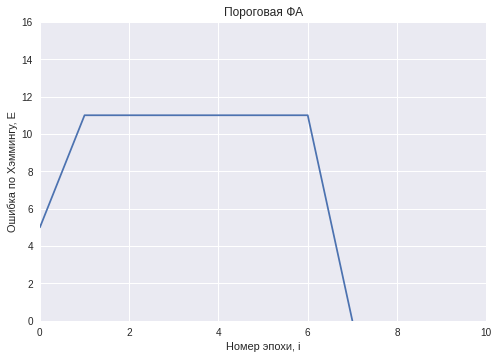

0110000001000000
E0, V=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Y=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=5
E1, V=[-0.3, -0.3, -0.04060058497098381, -0.014936120510359183, -0.1103638323514327, -0.04060058497098381], Y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=11
E2, V=[-0.3, -0.2743355355393754, -0.1103638323514327, -0.20457228815892647, -0.13602829681205733, -0.1103638323514327], Y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=11
E3, V=[0.0, -0.23373495056839158, -0.0697632473804489, -0.09420845580749378, -0.12109217630169815, -0.0697632473804489], Y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=11
E4, V=[0.0, -0.49313436559740775, -0.0697632473804489, 0.001219256033579

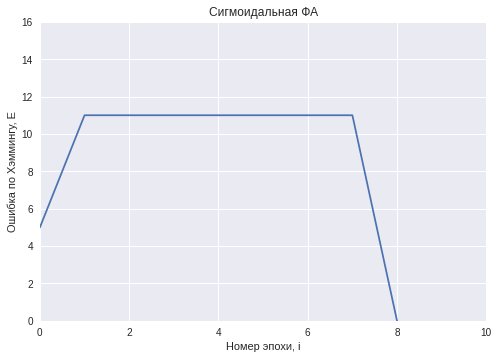

1010000010000000
E0, V=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Y=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=5
E1, V=[-0.075, -0.075, -0.010150146242745952, -0.0037340301275897957, -0.027590958087858174, -0.010150146242745952], Y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=11
E2, V=[-0.07523021458581397, -0.05764402346749567, -0.05764348766520683, -0.021205854029449217, -0.045062781989717596, -0.016577671056007846], Y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=11
E3, V=[-0.0005338908694210026, -0.03016478164114787, -0.030164245838859027, -0.011096805902557464, -0.03495373386282584, -0.012858760080311692], Y=[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], C=[(0, 0, 1, 0), (1, 0, 0, 0), (1, 0, 0, 1), (1, 0, 1, 0), (1, 0, 1, 1)], E=11
E4, V=[-0.0004803

In [33]:
    for f, df, name, short in ((f1, df1, 'Пороговая ФА', 'f1'), (f2, df2, 'Сигмоидальная ФА', 'f2')):
        print(find_min(f, df, Ys))

In [23]:
masks = ['0110000001000000', '1010000010000000']

for mask in masks:
    print(f"Маска {mask}")
    for s, m in zip(sets(4), mask):
        if m != '0':
            print(s)


Маска 0110000001000000
((0, 0, 0, 1), 1)
((0, 0, 1, 0), 0)
((1, 0, 0, 1), 0)
Маска 1010000010000000
((0, 0, 0, 0), 1)
((0, 0, 1, 0), 0)
((1, 0, 0, 0), 0)
